# Model Training and Evaluation

In [3]:
# !pip install fancyimpute imblearn optuna skrebate shap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from dotenv import load_dotenv
import os

# from neo4j import GraphDatabase

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from fancyimpute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from skrebate import ReliefF
from collections import Counter

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import optuna

from sklearn.model_selection import StratifiedKFold

import joblib
import pickle

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Connecting to Neo4j

def connect_to_neo4j(path):
    
    load_dotenv(path)

    uri = os.getenv("NEO4J_URI")
    user = os.getenv("NEO4J_USER")
    password = os.getenv("NEO4J_PASSWORD")

    # Creating a Neo4j Driver Instance
    driver = GraphDatabase.driver(uri, auth=(user, password))

    # Verifying Connection
    try:
        driver.verify_connectivity()
        print('Connected to database successfully.')
        return driver
    
    except Exception as err:
        print(f"Error: {err}, type: {type(err)}")

In [3]:
path = '../KG/db.env'

driver = connect_to_neo4j(path)

Connected to database successfully.


In [4]:
# Define a function to retrieve data from the knowledge graph based on suitable cypher queries 

def retrieve_data_from_graph(query):
    
    result_data = []

    with driver.session() as session:
        result = session.run(query)

        for record in result:
            result_data.append(dict(record))
    
    return result_data

In [5]:
# Function to retrieve all the data for a particular disease

def get_data_of_disease(disease):
    
    # Retrieve data for a specific disease from the knowledge graph.

    # Parameters:
    #     disease_name (str): The name of the disease to retrieve data for.

    # Returns:
    #     disease_df (pd.DataFrame): DataFrame containing person, disease, biomarker, and protein data.
    
    disease_query = """
    MATCH (p:Person)-[s:SUFFERS_FROM]->(d:Disease)
    where d.name = '"""+ disease +"""' and s.status IN ['Positive','Negative']
    RETURN p.respondentId as Respondent_ID,
    d.name AS DiseaseName,
    s.status AS DiseaseStatus;
    """

    disease_df = pd.DataFrame(retrieve_data_from_graph(disease_query))
    disease_data = disease_df.pivot(index=['Respondent_ID'],columns='DiseaseName', values='DiseaseStatus')
    disease_data = disease_data.reset_index()
    disease_data[disease] = disease_data[disease].map({'Negative': 0, 'Positive' : 1})

    biomarker_query = """
    MATCH (p:Person)-[s:SUFFERS_FROM]->(d:Disease)
    where d.name = '"""+ disease +"""' and s.status IN ['Positive','Negative']
    MATCH (p)-[h:HAS]->(b:BloodBiomarker)
    RETURN p.respondentId as Respondent_ID,
    p.gender AS Gender,
    p.age AS Age,
    p.bmi AS BMI,
    b.name AS BiomarkerName,
    b.unit AS BiomarkerUnit,
    h.value AS BiomarkerValue;
    """

    biomarker_df = pd.DataFrame(retrieve_data_from_graph(biomarker_query))
    biomarker_df['BloodBiomarker'] = np.where(biomarker_df['BiomarkerUnit'].notnull(),
                                       biomarker_df['BiomarkerName'] + ' [' + biomarker_df['BiomarkerUnit'] + ']',
                                       biomarker_df['BiomarkerName'])
    biomarker_data = biomarker_df.pivot(index=['Respondent_ID','Gender','Age','BMI'], 
                                        columns='BloodBiomarker',
                                        values='BiomarkerValue')
    biomarker_data = biomarker_data.reset_index()
    biomarker_data['Gender'] = biomarker_data['Gender'].map({'Female': 0, 'Male' : 1})


    protein_query = """
    MATCH (p:Person)-[s:SUFFERS_FROM]->(d:Disease)
    where d.name = '"""+ disease +"""' and s.status IN ['Positive','Negative']
    MATCH (p)-[h:HAS]->(b:BloodProtein)
    RETURN p.respondentId as Respondent_ID,
    b.name AS ProteinName,
    b.unit AS ProteinUnit,
    h.value AS ProteinValue;
    """

    protein_df = pd.DataFrame(retrieve_data_from_graph(protein_query))
    protein_df['BloodProtein'] = np.where(protein_df['ProteinUnit'].notnull(),
                                       protein_df['ProteinName'] + ' [' + protein_df['ProteinUnit'] + ']',
                                       protein_df['ProteinName'])
    protein_data = protein_df.pivot(index=['Respondent_ID'], 
                                        columns='BloodProtein',
                                        values='ProteinValue')
    protein_data = protein_data.reset_index()

    disease_df = biomarker_data.merge(protein_data, on='Respondent_ID',how='inner')
    disease_df = disease_df.merge(disease_data, on='Respondent_ID',how='inner')
    
    return disease_df

# Diabetes

In [6]:
# Data for Diabetes

diabetes_df = get_data_of_disease('Diabetes')
diabetes_df

,Respondent_ID,Gender,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],...,Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L],Diabetes
0,93703,0,2,17.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,93704,1,2,15.7,74.4,NaN,NaN,NaN,NaN,0.7,...,36.60,NaN,13.1,NaN,NaN,NaN,NaN,30.6,NaN,0
2,93705,0,66,31.7,89.9,1.517241,0.138,0.071,26.006,1.0,...,28.70,21.0,11.9,NaN,NaN,174.0,28.0,39.8,NaN,0
3,93706,1,18,21.5,53.8,1.629630,0.160,0.031,16.765,0.8,...,284.00,16.0,16.3,NaN,NaN,142.0,51.0,34.0,NaN,0
4,93707,1,13,18.1,58.2,1.857143,0.009,0.044,22.756,0.5,...,49.30,9.0,14.5,NaN,NaN,177.0,21.0,34.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8888,102952,0,70,20.0,82.7,1.846154,0.235,0.077,31.347,0.6,...,135.00,18.0,13.4,26.34,1.112,168.0,39.0,29.1,0.881,1
8889,102953,1,42,35.8,49.5,1.142857,0.106,0.080,21.873,0.6,...,120.00,28.0,15.5,NaN,NaN,136.0,20.0,28.6,NaN,0
8890,102954,0,41,26.1,50.5,1.500000,0.117,0.056,26.935,1.4,...,1.99,8.0,6.4,56.94,2.793,123.0,5.0,248.0,0.553,0
8891,102955,0,14,45.6,61.9,1.205882,0.031,0.079,17.856,0.9,...,11.40,16.0,11.4,NaN,NaN,158.0,5.0,57.7,NaN,0


## Pre-processing

In [35]:
# Seperate the attributes and labels

X = diabetes_df.drop(['Respondent_ID','Diabetes'],axis=1)
y = diabetes_df['Diabetes'].copy()

In [36]:
# Splitting the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [37]:
imputer = SimpleImputer(strategy='mean')

imputer.fit(X_train)

imputer.statistics_     # contains the mean values for each attribute

array([4.94658420e-01, 3.59339331e+01, 2.66632902e+01, 6.82204875e+00,
       3.58133427e+00, 1.34844354e+02, 1.54538462e+01, 4.33433108e+01,
       5.88022114e+01, 2.69357294e+01, 5.76856497e+00, 1.21308800e+00,
       2.80563585e+00, 4.08380899e+01, 1.63781259e+01, 5.17312568e-02,
       3.32056939e+00, 5.72086819e+00, 2.36572875e+00, 1.87938976e+02,
       9.39828822e-02, 5.47632135e-02, 3.65085070e-01, 2.02666800e-02,
       1.96819124e-01, 4.17317981e+00, 3.44511980e-01, 3.87772981e-01,
       5.37858134e-02, 1.99033503e-02, 7.16861458e-01, 1.71851328e+00,
       2.65182621e+01, 4.04619625e+01, 2.14831152e+01, 4.07785277e+00,
       9.10046423e+01, 2.18105932e+01, 2.55472773e+01, 1.46247362e+01,
       1.01035865e+02, 1.78782306e+02, 8.74950411e-01, 3.08708316e+00,
       2.97775433e+01, 8.73197552e+01, 1.59609324e+02, 2.80846349e+02,
       3.66912199e+00, 4.09615709e+00, 1.40336076e+02, 4.60772315e-01,
       9.31859434e+00, 7.16496412e+00, 5.41230477e+00, 4.65493249e+00,
      

In [38]:
X_train = imputer.transform(X_train)

X_train = pd.DataFrame(X_train, columns=X.columns)

# Data with null values imputed with mean
X_train

,Gender,Age,BMI,Chromium [nmol/L],Cobalt [nmol/L],Ferritin [ng/mL],Iron frozen [umol/L],UIBC [umol/L],Total Iron Binding Capacity [umol/L],Transferrin Saturation [%],...,Non_HDL Ratio,LDL_HDL Ratio,Total Cholestrol_HDL Ratio,Triglyceride_HDL Ratio,Lymphocyte_Monocyte Ratio,Neutrophil_Lymphocyte Ratio,Platelet_Lymphocyte Ratio,Platelet_WBC Ratio,Lymphocyte_C-Reactive Protein Ratio,Systemic Immune‐inflammation Index (SII)
0,0.0,64.0,33.0,5.580000,4.410000,99.300000,9.100000,44.600000,53.730000,17.000000,...,196.829080,2.782456,3.976608,0.521637,5.666667,1.882353,124.705882,40.000000,3.063063,399.058824
1,0.0,24.0,17.2,6.822049,3.581334,21.400000,12.900000,47.820000,60.710000,21.000000,...,84.686775,2.198828,2.319277,1.051555,4.400000,1.954545,108.181818,32.162162,38.596491,465.181818
2,1.0,11.0,17.6,6.822049,3.581334,134.844354,15.453846,43.343311,58.802211,26.935729,...,126.717164,2.198828,3.607286,1.051555,3.428571,1.041667,85.416667,31.538462,32.526564,213.541667
3,1.0,39.0,27.2,6.822049,3.581334,578.000000,17.600000,23.640000,41.190000,43.000000,...,252.900232,2.198828,9.720000,1.051555,3.200000,2.187500,89.375000,25.087719,10.126582,625.625000
4,1.0,64.0,33.7,5.580000,1.870000,72.800000,12.200000,44.950000,57.130000,21.000000,...,130.703790,2.198828,3.661417,1.051555,5.400000,1.037037,92.222222,40.161290,3.465982,258.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7109,0.0,51.0,25.6,5.580000,1.700000,109.000000,17.200000,32.780000,49.970000,34.000000,...,97.061098,1.269325,2.539877,0.658282,3.200000,2.937500,164.375000,38.115942,13.913043,772.562500
7110,0.0,53.0,20.3,5.580000,2.880000,186.000000,9.000000,34.210000,43.160000,21.000000,...,177.107502,2.198828,3.530387,1.051555,3.000000,1.833333,120.555556,36.779661,29.508197,397.833333
7111,0.0,5.0,17.7,6.822049,3.581334,18.900000,15.453846,43.343311,58.802211,26.935729,...,126.717164,2.198828,3.607286,1.051555,7.000000,1.257143,140.857143,56.666667,29.661017,619.771429
7112,0.0,77.0,27.9,5.580000,3.390000,134.844354,15.453846,43.343311,58.802211,26.935729,...,126.717164,2.198828,3.607286,1.051555,2.666667,2.250000,133.750000,35.666667,32.526564,481.500000


In [39]:
X_test = imputer.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X_train.columns)

In [40]:
y_train

7485    1.0
2023    0.0
3848    0.0
5982    0.0
1929    1.0
       ... 
5736    0.0
5193    0.0
5392    0.0
861     0.0
7274    0.0
Name: Diabetes, Length: 7114, dtype: float64

In [41]:
# Scaling the data

X_train_gender = X_train.Gender
X_train = X_train.drop('Gender',axis=1)
X_test_gender = X_test.Gender
X_test = X_test.drop('Gender',axis=1)
cols = X_train.columns

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

X_train.insert(0, "Gender", X_train_gender)
X_test.insert(0, "Gender", X_test_gender)

X_test

,Gender,Age,BMI,Chromium [nmol/L],Cobalt [nmol/L],Ferritin [ng/mL],Iron frozen [umol/L],UIBC [umol/L],Total Iron Binding Capacity [umol/L],Transferrin Saturation [%],...,Non_HDL Ratio,LDL_HDL Ratio,Total Cholestrol_HDL Ratio,Triglyceride_HDL Ratio,Lymphocyte_Monocyte Ratio,Neutrophil_Lymphocyte Ratio,Platelet_Lymphocyte Ratio,Platelet_WBC Ratio,Lymphocyte_C-Reactive Protein Ratio,Systemic Immune‐inflammation Index (SII)
0,1.0,0.881596,-0.251763,-3.033422e-01,-1.972523e-01,1.575279e+00,-0.397482,-0.642632,-1.078473e+00,-0.096893,...,1.252871e+00,1.929071e+00,1.042738,0.312474,-8.926291e-01,-8.005688e-01,-2.707712e-01,2.588412e-01,-0.553594,-7.768695e-01
1,1.0,-0.157171,-0.444116,-2.169174e-16,-2.033998e-16,5.697166e-02,1.503334,-0.568876,3.345052e-01,1.145681,...,-3.551930e-01,7.947699e-16,-0.320510,0.000000,-5.816549e-02,-7.319322e-01,9.257540e-03,1.008882e+00,0.058779,-4.735593e-01
2,0.0,1.760552,0.000000,-2.169174e-16,-2.033998e-16,-1.768561e-16,0.000000,0.000000,-9.044878e-16,0.000000,...,3.992918e-16,7.947699e-16,0.000000,0.000000,3.645013e-16,2.119477e-16,6.637964e-16,-6.022244e-16,0.000000,-1.963367e-16
3,0.0,-0.996174,-1.149409,-2.169174e-16,-2.033998e-16,-1.768561e-16,0.000000,0.000000,-9.044878e-16,0.000000,...,3.992918e-16,7.947699e-16,0.000000,0.000000,3.645013e-16,2.119477e-16,6.637964e-16,-6.022244e-16,0.000000,-1.963367e-16
4,0.0,1.201216,0.299648,2.326986e+00,-3.140463e-01,-5.609296e-01,-0.840391,1.247369,9.735278e-01,-1.132371,...,2.056903e+00,7.947699e-16,1.764494,0.000000,1.754399e+00,-1.169337e+00,-6.064487e-01,9.977358e-01,-0.597879,-9.276909e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1774,1.0,-1.355748,-1.457173,-2.169174e-16,-2.033998e-16,-5.596851e-01,0.000000,0.000000,-9.044878e-16,0.000000,...,3.992918e-16,7.947699e-16,0.000000,0.000000,8.720563e-01,-5.817443e-01,-2.147678e-01,3.818198e-01,0.957056,-8.252153e-02
1775,0.0,-0.756459,0.594589,-2.169174e-16,-2.033998e-16,-7.077823e-01,-0.840391,1.706296,1.542538e+00,-1.235919,...,3.727821e-01,7.947699e-16,0.840670,0.000000,-1.037646e-01,4.138871e-01,-6.587785e-01,-1.114727e+00,-0.503977,1.063278e+00
1776,1.0,-1.155985,-1.136586,-2.169174e-16,-2.033998e-16,-1.768561e-16,0.000000,0.000000,-9.044878e-16,0.000000,...,3.992918e-16,7.947699e-16,0.000000,0.000000,8.720563e-01,-9.577703e-01,-5.615580e-01,5.534677e-01,0.000000,-7.183701e-01
1777,1.0,0.162450,0.081649,-3.033422e-01,-2.361836e-01,2.685391e-01,-0.508209,0.641954,4.490710e-01,-0.718180,...,1.752675e+00,3.223491e+00,3.367175,6.460474,4.206251e-01,-3.214187e-01,-1.369170e-01,1.749970e-01,-0.188168,-3.431409e-01


### Pipeline for Pre-processing

In [6]:
# We can define a function to do all the preprocessing and the splitting of data

def preprocess_and_split(df, label, impute=True, scale=True, imputer = SimpleImputer(),
                         scaler = StandardScaler(), test_size=0.2, val_size=0.5, random_state=42):
    
    # Preprocesses the input dataframe and splits it into training and testing sets.
    
    if 'Respondent_ID' in df.columns:
        X = df.drop(['Respondent_ID'], axis=1)
        X = X.drop([label], axis=1)
    else:    
        X = df.drop([label], axis=1)
        
    y = df[label].copy()
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_train, y_train, test_size=val_size, random_state=random_state)
    
    # Separate categorical and numerical columns 
    if 'Gender' in df.columns:
        categorical_cols = ['Gender']
    else:
        categorical_cols = []
    numeric_cols = [col for col in X.columns if col not in categorical_cols]
    
    # Preprocessing for numerical data
    numeric_transformer = Pipeline(steps=[
        ('imputer', imputer) if impute else ('imputer', 'passthrough'),
        ('scaler', scaler) if scale else ('scaler', 'passthrough')
    ])
    
    # Preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('pass', 'passthrough')])
    
    # Column Transformer for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_cols),
            ('num', numeric_transformer, numeric_cols)
        ])
    
    # Preprocess the data
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    X_val = preprocessor.transform(X_val)
    X = preprocessor.transform(X)

    
    X_train = pd.DataFrame(X_train, columns= categorical_cols + numeric_cols)
    X_test = pd.DataFrame(X_test, columns= categorical_cols + numeric_cols)
    X_val = pd.DataFrame(X_val, columns= categorical_cols + numeric_cols)
    X = pd.DataFrame(X, columns= categorical_cols + numeric_cols)

    return X, y, X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
# Attributes and Labels

X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=SimpleImputer(strategy='mean'),
                                                              random_state=42)

In [8]:
X

,Gender,Age,BMI,Chromium [nmol/L],Cobalt [nmol/L],Ferritin [ng/mL],Iron frozen [umol/L],UIBC [umol/L],Total Iron Binding Capacity [umol/L],Transferrin Saturation [%],...,Non_HDL Ratio,LDL_HDL Ratio,Total Cholestrol_HDL Ratio,Triglyceride_HDL Ratio,Lymphocyte_Monocyte Ratio,Neutrophil_Lymphocyte Ratio,Platelet_Lymphocyte Ratio,Platelet_WBC Ratio,Lymphocyte_C-Reactive Protein Ratio,Systemic Immune‐inflammation Index (SII)
0,0.0,-1.355748,-1.175056,-2.169174e-16,-2.033998e-16,-1.768561e-16,0.000000,0.000000,-9.044878e-16,0.000000,...,3.992918e-16,7.947699e-16,0.000000,0.000000,3.645013e-16,2.119477e-16,6.637964e-16,-6.022244e-16,0.000000,-1.963367e-16
1,1.0,-1.355748,-1.405879,-2.169174e-16,-2.033998e-16,-6.113325e-01,0.000000,0.000000,-9.044878e-16,0.000000,...,3.992918e-16,7.947699e-16,0.000000,0.000000,5.574224e-01,-9.238866e-01,-1.153629e+00,-4.505094e-01,1.986583,-9.015393e-01
2,0.0,1.201216,0.645883,-3.033422e-01,-4.381705e-02,-6.604908e-01,0.193063,-0.165266,-7.538575e-02,0.110203,...,-8.332662e-01,7.947699e-16,-0.850187,0.000000,4.890238e-01,-6.174753e-01,-6.258787e-01,-1.425979e-01,-0.451260,-3.378768e-01
3,1.0,-0.716507,-0.662115,-2.169174e-16,-2.033998e-16,9.281316e-01,2.573697,-1.596340,-2.128647e-01,2.491802,...,-7.246132e-01,7.947699e-16,-0.402698,0.000000,-8.105507e-01,5.579036e-01,8.793906e-01,4.949961e-02,-0.276172,3.288385e-01
4,1.0,-0.916269,-1.098115,-2.169174e-16,-2.033998e-16,-5.323058e-01,0.156154,1.797467,2.340680e+00,-0.614632,...,-1.596176e-01,7.947699e-16,-0.713309,0.000000,6.258211e-01,-4.102600e-01,-8.133095e-01,-5.544085e-01,2.224540,8.946036e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8888,0.0,1.361027,-0.854468,-3.033422e-01,-2.361836e-01,9.685184e-04,1.614061,-0.531998,4.490710e-01,1.249229,...,-1.898066e+00,-2.651222e+00,-1.394291,-0.597326,1.023317e-02,-2.587477e-01,-6.594614e-01,-5.122682e-01,0.168399,-7.603587e-01
8889,1.0,0.242355,1.171648,1.479517e+00,-3.529777e-01,-9.237005e-02,-0.545118,0.623515,4.032447e-01,-0.718180,...,1.772067e-01,7.947699e-16,0.087241,0.000000,-2.633615e-01,2.784622e-01,-4.433971e-01,-8.698713e-01,-0.451260,4.818408e-02
8890,0.0,0.202402,-0.072234,-3.033422e-01,3.404562e-02,-8.266956e-01,-2.150662,3.650589,3.047169e+00,-2.271397,...,-2.465400e-01,-3.647832e-01,-0.368940,-0.811679,-3.317601e-01,-9.288452e-01,-1.209136e+00,-7.781680e-01,-0.120914,-1.200987e+00
8891,0.0,-0.876317,2.428352,-2.169174e-16,-2.033998e-16,-7.681412e-01,-2.224480,2.660004,1.770397e+00,-2.271397,...,-3.008665e-01,7.947699e-16,0.690011,0.000000,1.128312e-01,-1.387340e-01,-4.006414e-01,-3.478301e-01,-0.565358,6.353469e-01


## Model Training & Evaluation

# Logistic Regression

In [45]:
log_reg = LogisticRegression()

In [46]:
# Training

log_reg.fit(X_train, y_train)

# Accuracy scores

y_pred = log_reg.predict(X_val)

print('Training Accuracy: ',accuracy_score(y_train, log_reg.predict(X_train)))

print('Testing Accuracy: ',accuracy_score(y_val, y_pred))

Training Accuracy:  0.9384312622996908
Testing Accuracy:  0.9389935338768626


In [47]:
X_val

,Gender,Respondent ID,Age,BMI,Chromium [nmol/L],Cobalt [nmol/L],Ferritin [ng/mL],Iron frozen [umol/L],UIBC [umol/L],Total Iron Binding Capacity [umol/L],...,Non_HDL Ratio,LDL_HDL Ratio,Total Cholestrol_HDL Ratio,Triglyceride_HDL Ratio,Lymphocyte_Monocyte Ratio,Neutrophil_Lymphocyte Ratio,Platelet_Lymphocyte Ratio,Platelet_WBC Ratio,Lymphocyte_C-Reactive Protein Ratio,Systemic Immune‐inflammation Index (SII)
0,1.0,-0.420754,0.442118,0.402237,-3.033422e-01,-2.361836e-01,5.298870e-01,-0.508209,0.164588,-1.441252e-01,...,7.639328e-01,7.947699e-16,3.765153,0.000000,6.258211e-01,2.715453e-01,-5.426851e-01,-8.258447e-01,-0.673012,-3.840655e-01
1,1.0,-1.294667,0.921548,-0.264586,-3.033422e-01,-1.972523e-01,2.377991e+00,0.026972,-1.376096,-1.694582e+00,...,-6.920173e-01,7.947699e-16,-0.285215,0.000000,-2.633615e-01,-8.420700e-01,-3.113891e-01,5.105395e-01,-0.278309,-8.273278e-01
2,1.0,-1.249225,1.760552,0.068825,-3.033422e-01,-2.751150e-01,2.187585e-01,1.411062,-0.990925,-2.586910e-01,...,-8.332662e-01,-1.820279e+00,-1.082449,-0.842054,-1.015747e+00,8.283530e-01,6.964411e-01,-3.573690e-01,-0.589095,2.494472e-02
3,0.0,1.410069,-0.037313,0.000000,-2.169174e-16,-2.033998e-16,-1.768561e-16,0.000000,0.000000,-9.044878e-16,...,3.992918e-16,7.947699e-16,0.000000,0.000000,3.645013e-16,2.119477e-16,6.637964e-16,-6.022244e-16,0.000000,-1.963367e-16
4,0.0,-0.917236,-1.076080,-1.226350,-2.169174e-16,-2.033998e-16,-1.768561e-16,0.000000,0.000000,-9.044878e-16,...,-1.713355e+00,7.947699e-16,-1.198779,0.000000,3.645013e-16,2.119477e-16,6.637964e-16,-6.022244e-16,0.000000,-1.963367e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3552,0.0,-1.312318,1.400979,0.492001,-3.033422e-01,-1.972523e-01,2.747616e-01,0.414517,-1.118974,-1.101386e+00,...,-1.452588e+00,-2.024262e+00,-1.166656,-0.840592,-5.816549e-02,-6.585070e-01,-7.812281e-01,-3.755413e-01,-0.427788,-7.543954e-01
3553,1.0,0.894434,-1.395700,0.000000,-2.169174e-16,-2.033998e-16,-1.768561e-16,0.000000,0.000000,-9.044878e-16,...,3.992918e-16,7.947699e-16,0.000000,0.000000,3.645013e-16,2.119477e-16,6.637964e-16,-6.022244e-16,0.000000,-1.963367e-16
3554,0.0,-1.124541,-1.076080,-0.674939,-2.169174e-16,-2.033998e-16,-1.768561e-16,0.000000,0.000000,-9.044878e-16,...,7.639328e-01,7.947699e-16,1.520064,0.000000,-4.514578e-01,-6.299528e-01,-8.194882e-01,-5.628168e-01,-0.584171,-7.148812e-01
3555,1.0,-0.754621,1.321074,-1.277644,-3.033422e-01,-4.381705e-02,7.250264e+00,0.000000,0.000000,-9.044878e-16,...,-1.061437e+00,7.947699e-16,-0.376479,0.000000,-1.549256e+00,6.385066e+00,7.728042e+00,1.808804e-01,0.000000,7.639887e+00


In [48]:
# Confusion matrix

print(confusion_matrix(y_val, y_pred))

[[3032   41]
 [ 176  308]]


In [49]:
# Classification report

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      3073
         1.0       0.88      0.64      0.74       484

    accuracy                           0.94      3557
   macro avg       0.91      0.81      0.85      3557
weighted avg       0.94      0.94      0.93      3557



In [50]:
# Function for model evaluation

def evaluate_model_metrics(model,X_train,y_train,X_test,y_test, verbose=3):
    
    y_pred = model.predict(X_test)
    
    # Accuracy
    if verbose >= 0:
        train_accuracy = accuracy_score(y_train, model.predict(X_train))
        test_accuracy = accuracy_score(y_test, y_pred)
        print(f'\nTrain Accuracy: {train_accuracy:.3f}')
        print(f'\nTest Accuracy: {test_accuracy:.3f}')

    # Precision
    if verbose >= 1:
        precision = precision_score(y_test, y_pred)
        print(f'\nPrecision: {precision:.3f}')

    # Recall
    if verbose >= 2:
        recall = recall_score(y_test, y_pred)
        print(f'\nRecall: {recall:.3f}')

    # F1-score
    if verbose >= 3:
        f1 = f1_score(y_test, y_pred)
        print(f'\nF1-Score: {f1:.3f}')

    # Confusion Matrix
    if verbose >= 4:
        conf_matrix = confusion_matrix(y_test, y_pred)
        print('\nConfusion Matrix:\n')
        print(conf_matrix)

    # Classification Report
    if verbose >= 5:
        class_report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
        print('\n\nClassification Report:\n')
        print(class_report)

    # ROC Curve and AUC
    if verbose >= 6:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        print('\nROC-AUC Curve:')
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='lightcoral', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()


Train Accuracy: 0.938

Test Accuracy: 0.938

Precision: 0.879

Recall: 0.616

F1-Score: 0.724

Confusion Matrix:

[[3046   40]
 [ 181  290]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.94      0.99      0.96      3086
     Class 1       0.88      0.62      0.72       471

    accuracy                           0.94      3557
   macro avg       0.91      0.80      0.84      3557
weighted avg       0.94      0.94      0.93      3557


ROC-AUC Curve:


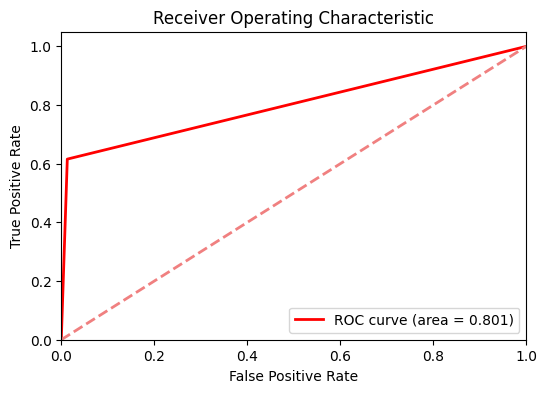

In [51]:
evaluate_model_metrics(log_reg,X_train,y_train,X_test,y_test, verbose=6)

## Feature Selection

In [52]:
# Using all the features to train the model may result in overfitting
# This can be avoided by performing feature extraction
# We can use a combination of various methods along with domain knowledge to select the features
# As we shall see, most of the insights derived from these methods seem to be in agreement with current research

### Correlation Analysis

In [53]:
# Function to check which features are more correlated with the disease

def get_correlated_features(df,disease,pos,neg):
    
    corr_df = df.corr()[disease].sort_values(ascending=False)
    pos_corr = corr_df[corr_df>pos]
    neg_corr = corr_df[corr_df<neg]
    
    return pos_corr, neg_corr

In [54]:
pos_corr, neg_corr = get_correlated_features(diabetes_df,'Diabetes',pos=0.1,neg=-0.1)

print('Positive Correlation\n\n',pos_corr,sep='')
print('\n\nNegative Correlation\n\n',neg_corr,sep='')

Positive Correlation

Diabetes                              1.000000
Glycohemoglobin [%]                   0.616415
Fasting Glucose [mmol/L]              0.610611
Age                                   0.396039
BMI                                   0.269706
Blood Urea Nitrogen [mg/dL]           0.242561
Insulin [pmol/L]                      0.234273
Osmolality [mmol/Kg]                  0.224238
Retinol [umol/L]                      0.213473
Triglyceride [mmol/L]                 0.167136
Alpha-tocopherol [umol/L]             0.162476
Triglyceride_HDL Ratio                0.156951
Segmented neutrophils [%]             0.153802
Neutrophil_Lymphocyte Ratio           0.147970
C-Reactive Protein [mg/L]             0.137446
Creatinine [mg/dL]                    0.132612
Ferritin [ng/mL]                      0.130874
Red cell distribution width [%]       0.124067
25-hydroxyvitamin D2 + D3 [nmol/L]    0.104823
Total Cholestrol_HDL Ratio            0.104507
Mean platelet volume [fL]             

In [55]:
# Evaluating the performance of a model on the selected features for comparison

corr_features = list(pos_corr.keys()[1:10]) + list(neg_corr.keys()[:10]) 

In [56]:
def evaluate_feature_set(feature_set, model, X_train,y_train,X_val,y_val, verbose=3):
    
    X_train = X_train[feature_set]
    X_val = X_val[feature_set]

    model.fit(X_train, y_train)

    evaluate_model_metrics(model,X_train,y_train,X_val,y_val, verbose=verbose)

In [57]:
evaluate_feature_set(corr_features,LogisticRegression(),X_train,y_train,X_val,y_val)


Train Accuracy: 0.935

Test Accuracy: 0.935

Precision: 0.878

Recall: 0.610

F1-Score: 0.720


### Select From Model

In [58]:
# SelectFromModel can be used with any estimator that exposes feature importance

def select_from_model_features(model,X,y):

    sfm = SelectFromModel(model)  

    
    sfm.fit_transform(X, y)

    
    selected_features = sfm.get_support()
    feature_names = X.columns
    sfm_features = [feature_names[i] for i, selected in enumerate(selected_features) if selected]

    return sfm_features

In [59]:
sfm_features = select_from_model_features(log_reg,X,y)
sfm_features

['Age',
 'BMI',
 'UIBC [umol/L]',
 'Total Iron Binding Capacity [umol/L]',
 'Glycohemoglobin [%]',
 'Retinyl palmitate [umol/L]',
 'Retinol [umol/L]',
 'Transferrin receptor [nmol/L]',
 'Alkaline Phosphatase [IU/L]',
 'Osmolality [mmol/Kg]',
 'Sodium [mmol/L]',
 'Total Cholesterol [mmol/L]',
 'Vitamin C [umol/L]',
 'Fasting Glucose [mmol/L]',
 'White blood cell count [1000 cells/uL]',
 'RBC count [million cells/uL]',
 'Hemoglobin [g/dL]',
 'Mean cell volume [fL]',
 'Mean cell hemoglobin [pg]',
 'Mean Cell Hgb Conc. [g/dL]',
 'Insulin [pmol/L]',
 'Non_HDL Ratio',
 'Total Cholestrol_HDL Ratio',
 'Triglyceride_HDL Ratio']

In [60]:
evaluate_feature_set(sfm_features,LogisticRegression(),X_train,y_train,X_val,y_val)


Train Accuracy: 0.938

Test Accuracy: 0.937

Precision: 0.869

Recall: 0.630

F1-Score: 0.731


### SelectKBest

In [61]:
# Function to select features using SelectKBest using anova scores

def select_k_best(X,y,n):
    
    select = SelectKBest(score_func = f_classif, k = n)
    
    z = select.fit_transform(X,y)

    feature_rankings = select.scores_
    feature_rankings_df = pd.DataFrame({'Feature': X.columns, 'Ranking': feature_rankings})
    sorted_features = feature_rankings_df.sort_values(by='Ranking',ascending=False)
    
    return sorted_features.Feature.values

In [62]:
k_best_features = select_k_best(X, y, n=30)
k_best_features[:30]

array(['Glycohemoglobin [%]', 'Fasting Glucose [mmol/L]', 'Age', 'BMI',
       'Blood Urea Nitrogen [mg/dL]', 'Osmolality [mmol/Kg]',
       'Retinol [umol/L]', 'Lymphocyte [%]', 'Insulin [pmol/L]',
       'Alpha-tocopherol [umol/L]', 'Lymphocyte_C-Reactive Protein Ratio',
       'Segmented neutrophils [%]', 'Neutrophil_Lymphocyte Ratio',
       'Alpha-crypotoxanthin [umol/L]', 'Albumin [g/dL]',
       'Direct HDL-Cholesterol [mmol/L]', 'Platelet_WBC Ratio',
       'C-Reactive Protein [mg/L]', 'Creatinine [mg/dL]',
       'Ferritin [ng/mL]', 'Chloride [mmol/L]',
       'Red cell distribution width [%]', 'Triglyceride [mmol/L]',
       'A/G Ratio', 'Platelet count [1000 cells/uL]',
       'Triglyceride_HDL Ratio', 'Trans-lycopene [umol/L]',
       '25-hydroxyvitamin D2 + D3 [nmol/L]', 'Total Lycopene [umol/L]',
       'Mean platelet volume [fL]'], dtype=object)

In [63]:
evaluate_feature_set(k_best_features[:30],LogisticRegression(),X_train,y_train,X_val,y_val)


Train Accuracy: 0.936

Test Accuracy: 0.936

Precision: 0.879

Recall: 0.618

F1-Score: 0.726


### Recursive Feature Elimination (RFE) 

In [64]:
#  RFE is a method that recursively removes the least important features from the dataset

def select_rfe_features(model,X,y,n,step):
    
    rfe = RFE(model,n_features_to_select=n,step=step)
    fit = rfe.fit(X, y)

    feature_rankings = rfe.ranking_
    feature_rankings_df = pd.DataFrame({'Feature': X.columns, 'Ranking': feature_rankings})
    sorted_features = feature_rankings_df.sort_values(by='Ranking')
    
    return list(sorted_features.Feature.values)

In [65]:
rfe_features = select_rfe_features(log_reg,X,y,n=30,step=0.2)
rfe_features[:30]

['Albumin [g/dL]',
 'Retinyl stearate [umol/L]',
 'Retinol [umol/L]',
 'Transferrin receptor [nmol/L]',
 'Non_HDL Ratio',
 'Mean cell hemoglobin [pg]',
 'Alkaline Phosphatase [IU/L]',
 'Aspartate Aminotransferase [U/L]',
 'Gamma Glutamyl Transferase [IU/L]',
 'Iron [ug/dL]',
 'Total Cholesterol [mmol/L]',
 'Vitamin C [umol/L]',
 'Insulin [pmol/L]',
 'Fasting Glucose [mmol/L]',
 'RBC count [million cells/uL]',
 'Hemoglobin [g/dL]',
 'Hematocrit [%]',
 'Mean cell volume [fL]',
 'Retinyl palmitate [umol/L]',
 'Total Cholestrol_HDL Ratio',
 'Mean Cell Hgb Conc. [g/dL]',
 'Iron frozen [umol/L]',
 'UIBC [umol/L]',
 'Platelet_WBC Ratio',
 'Triglyceride_HDL Ratio',
 'Age',
 'Glycohemoglobin [%]',
 'Triglyceride [mmol/L]',
 'BMI',
 'Total Iron Binding Capacity [umol/L]']

In [66]:
evaluate_feature_set(rfe_features[:30],LogisticRegression(),X_train,y_train,X_val,y_val)


Train Accuracy: 0.937

Test Accuracy: 0.937

Precision: 0.868

Recall: 0.636

F1-Score: 0.734


### Lasso Regularization

In [67]:
# Uses lasso regularization to give more weights to more important features

def log_reg_lasso_select(X_train,y_train,solver='saga'):
    l1_reg_model = LogisticRegression(penalty='l1', solver=solver)
    l1_reg_model.fit(X_train, y_train)

    # Get feature importance coefficients from the model
    feature_importance = l1_reg_model.coef_[0]

    feature_importance_pairs = [(feature, importance) for feature, importance in zip(X.columns, feature_importance)]
    feature_importance_pairs.sort(key=lambda x: abs(x[1]), reverse=True)

    l1_sorted_features = [feature for feature, _ in feature_importance_pairs]

    return l1_sorted_features

In [68]:
l1_selected_features = log_reg_lasso_select(X_train,y_train)
l1_selected_features[:30]

['Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'Gender',
 'BMI',
 'Retinol [umol/L]',
 'Total Cholesterol [mmol/L]',
 'Non_HDL Ratio',
 'Alkaline Phosphatase [IU/L]',
 'Insulin [pmol/L]',
 'Osmolality [mmol/Kg]',
 'Vitamin C [umol/L]',
 'Blood lead [umol/L]',
 'Transferrin receptor [nmol/L]',
 'Mean Cell Hgb Conc. [g/dL]',
 'Gamma Glutamyl Transferase [IU/L]',
 'Aspartate Aminotransferase [U/L]',
 'Transferrin Saturation [%]',
 'Creatine Phosphokinase [IU/L]',
 'LDL-Cholesterol(NIH2) [mmol/L]',
 'Lactate Dehydrogenase [IU/L]',
 'Creatinine [mg/dL]',
 'White blood cell count [1000 cells/uL]',
 'Total Cholestrol_HDL Ratio',
 'Platelet_Lymphocyte Ratio',
 'Retinyl palmitate [umol/L]',
 'Uric Acid [mg/dL]',
 'Bicarbonate [mmol/L]',
 'Direct HDL-Cholesterol [mmol/L]',
 'Blood selenium [umol/L]']

In [69]:
evaluate_feature_set(l1_selected_features[:30],LogisticRegression(),X_train,y_train,X_val,y_val)


Train Accuracy: 0.938

Test Accuracy: 0.939

Precision: 0.887

Recall: 0.630

F1-Score: 0.737


### Relief F

In [70]:
# It focuses on selecting features that are relevant to the target class

def relief_feature_select(n,X,y,n_jobs=-1):
    
    fs = ReliefF(n_features_to_select=n, n_jobs=n_jobs)
    fs.fit(X.values, y.values)

    feature_importances = fs.feature_importances_
    
    feature_names = X.columns
    feature_importance_tuples = list(zip(feature_names, feature_importances))
    sorted_features = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)
    sorted_feature_names = [feature[0] for feature in sorted_features]
    relieff_features = sorted_feature_names
    
    return relieff_features

In [71]:
relieff_features = relief_feature_select(30,X,y)

In [72]:
relieff_features[:30]

['Age',
 'Glycohemoglobin [%]',
 'Respondent ID',
 'BMI',
 'Fasting Glucose [mmol/L]',
 'Segmented neutrophils [%]',
 'Hematocrit [%]',
 'Lymphocyte [%]',
 'Retinol [umol/L]',
 'Hemoglobin [g/dL]',
 'Total Cholesterol [mmol/L]',
 'Neutrophil_Lymphocyte Ratio',
 'Non_HDL Ratio',
 'Osmolality [mmol/Kg]',
 'Total Iron Binding Capacity [umol/L]',
 'Alpha-tocopherol [umol/L]',
 'Blood Urea Nitrogen [mg/dL]',
 'Potassium [mmol/L]',
 'Chloride [mmol/L]',
 'Mean cell volume [fL]',
 'Sodium [mmol/L]',
 'Total Protein [g/dL]',
 'Total Calcium [mg/dL]',
 'Total Cholestrol_HDL Ratio',
 'Gamma-tocopherol [umol/L]',
 'Lactate Dehydrogenase [IU/L]',
 'Phosphorus [mg/dL]',
 'A/G Ratio',
 'Uric Acid [mg/dL]',
 'Mean platelet volume [fL]']

In [73]:
evaluate_feature_set(relieff_features[:30],LogisticRegression(),X_train,y_train,X_val,y_val)


Train Accuracy: 0.936

Test Accuracy: 0.937

Precision: 0.880

Recall: 0.622

F1-Score: 0.729


### Optimal no. of features

In [74]:
# Now let us find out the optimal number of features to use for training from the best feature set
# By evaluating the model on increasing number of features, we can obtain the optimal number of features

def plot_num_feature_performance(model, X, y, feature_set, num_folds=10, scoring='accuracy', verbose=False):
    
    num_features_list = []
    accuracy_list = []

    # Evaluating the model for each set of number of features
    for num_features in range(5, len(feature_set) + 1):

        X_subset = X[feature_set[:num_features]]

        cv_scores = cross_val_score(model, X_subset, y, cv=num_folds, scoring=scoring)

        avg_score = cv_scores.mean()
        
        num_features_list.append(num_features)
        accuracy_list.append(avg_score)
        
        if verbose:
            print(f'Features: {num_features}, {scoring}: {avg_score:.4f}')

    max_score = max(accuracy_list)
    max_score_num_feature = num_features_list[accuracy_list.index(max_score)]
    
    print(f'\nMaximum {scoring} = {max_score:.4f} for {max_score_num_feature} features')

    plt.figure(figsize=(10, 7))
    plt.plot(num_features_list, accuracy_list, marker='o', color='red', linestyle='-')
    plt.title('Model Performance vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel(scoring)
    plt.show()


Maximum accuracy = 0.9391 for 15 features


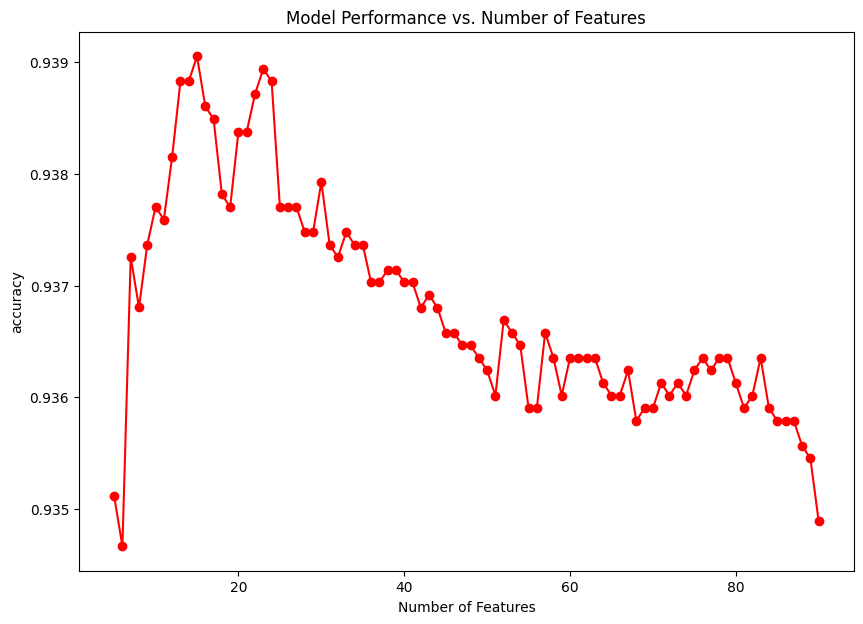

In [77]:
final_features = list(l1_selected_features) 

plot_num_feature_performance(LogisticRegression(), X, y, final_features, scoring='accuracy')


Maximum f1 = 0.7292 for 23 features


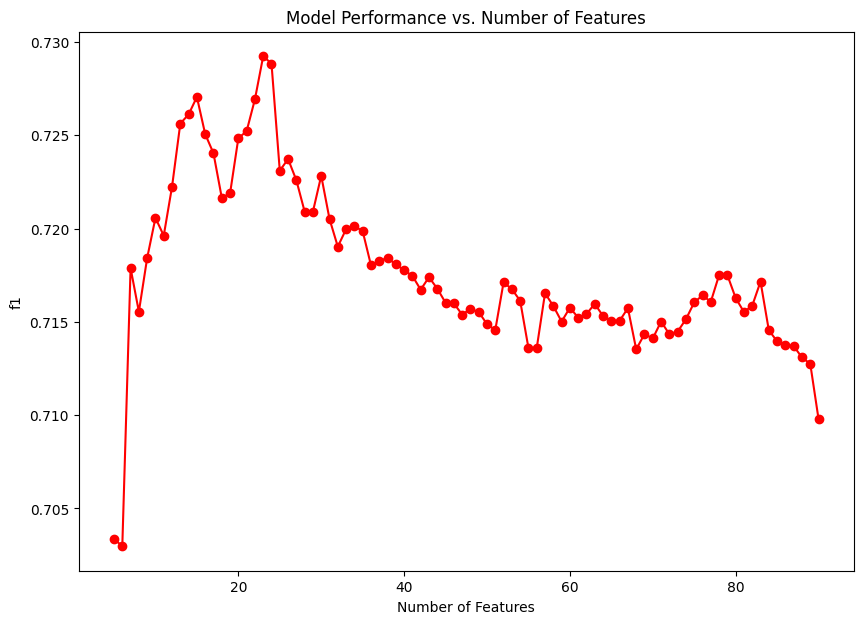

In [78]:
plot_num_feature_performance(LogisticRegression(), X, y, final_features, scoring='f1')

In [80]:
num_features = 23

selected = rfe_features[:num_features]
selected.append('Diabetes')

diabetes_df = diabetes_df[selected]

In [81]:
# Save feature set

feature_dir = "../Models/Diabetes/Feature Sets"
if not os.path.exists(feature_dir):
    os.makedirs(feature_dir)
    
with open('../Models/Diabetes/Feature Sets/Logistic Regression Features.pkl', 'wb') as f:
    pickle.dump(selected, f)

## Spliting Data and Imputation

### Zero Imputation

In [82]:
# Imputing null values with zeroes

X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True, 
                                                              imputer=SimpleImputer(strategy='constant',fill_value=0),
                                                              random_state=42)

In [83]:
log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg,X_train,y_train,X_val,y_val)


Train Accuracy: 0.882

Test Accuracy: 0.878

Precision: 0.727

Recall: 0.165

F1-Score: 0.269


### Mode Imputation

In [84]:
# Imputing with most frequent values

X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True, 
                                                              imputer=SimpleImputer(strategy='most_frequent'),
                                                              random_state=42)

In [85]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg,X_train,y_train,X_val,y_val)


Train Accuracy: 0.905

Test Accuracy: 0.902

Precision: 0.828

Recall: 0.349

F1-Score: 0.491


### k-NN Imputation

In [86]:
# Imputing missing values with values from the k-nearest neighbors in the feature space

X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True, 
                                                              imputer=KNNImputer(n_neighbors=20),
                                                              random_state=42)

In [87]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg,X_train,y_train,X_val,y_val)


Train Accuracy: 0.903

Test Accuracy: 0.900

Precision: 0.842

Recall: 0.331

F1-Score: 0.475


### Multiple Imputation by Chained Equations (MICE)

In [88]:
# Imputes by looking at data from other columns and trying to estimate the best prediction for each missing value.

X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True, 
                                                              imputer=IterativeImputer(max_iter=20),
                                                              random_state=42)

In [89]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg,X_train,y_train,X_val,y_val)


Train Accuracy: 0.906

Test Accuracy: 0.904

Precision: 0.864

Recall: 0.353

F1-Score: 0.501


### Median Imputation

In [90]:
# Imputing with median values

X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True, 
                                                              imputer=SimpleImputer(strategy='median'),
                                                              random_state=42)

In [91]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg,X_train,y_train,X_val,y_val)


Train Accuracy: 0.906

Test Accuracy: 0.902

Precision: 0.837

Recall: 0.349

F1-Score: 0.493


### Mean Imputation

In [92]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True, 
                                                              imputer=SimpleImputer(strategy='mean'),
                                                              random_state=42)

In [93]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg,X_train,y_train,X_val,y_val)


Train Accuracy: 0.906

Test Accuracy: 0.903

Precision: 0.856

Recall: 0.345

F1-Score: 0.492


### Dropping Null Values

In [94]:
# Drop null values
diabetes_df_na = diabetes_df.dropna()

X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocess_and_split(df = diabetes_df_na, label = 'Diabetes',
                                                              impute = False, scale=True, 
                                                              random_state=42)

In [95]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg,X_train,y_train,X_val,y_val)


Train Accuracy: 0.930

Test Accuracy: 0.932

Precision: 0.937

Recall: 0.738

F1-Score: 0.825


## Oversampling and Undersampling

In [96]:
# Oversampling and undersampling are techniques used to adjust the class distribution of a data set.
# Library -> imblearn

In [97]:
def plot_class_dist(y):
    
    class_distribution = y.value_counts()
    plt.figure(figsize=(5,4))
    class_distribution.plot(kind='barh', color=['lightcoral', 'indianred'])
    plt.xlabel('Count')
    plt.ylabel('Class')
    plt.title('Class Distribution')
    plt.grid(False)
    plt.show()

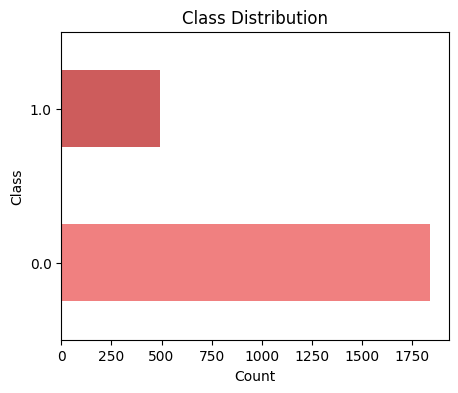

In [98]:
# Class distribution
plot_class_dist(y)

### Random Oversampling

In [99]:
# Repeatedly sample instances from the minority class with replacement.

def random_over_sample(X_train, y_train, sampling_strategy='auto', random_state=42):
    
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=random_state)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    
    return X_resampled, y_resampled

In [100]:
X_ros, y_ros = random_over_sample(X_train,y_train)

log_reg = LogisticRegression()
log_reg.fit(X_ros, y_ros)

evaluate_model_metrics(log_reg,X_ros, y_ros,X_val,y_val)


Train Accuracy: 0.875

Test Accuracy: 0.885

Precision: 0.699

Recall: 0.827

F1-Score: 0.757


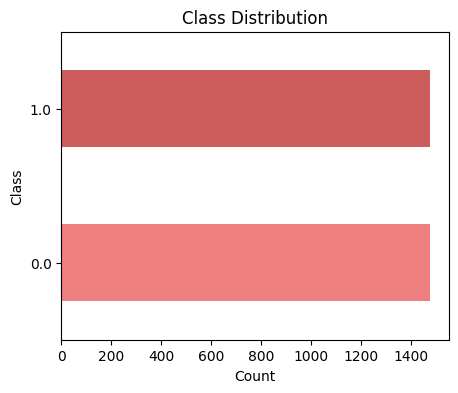

In [101]:
plot_class_dist(y_ros)

### SMOTE (Synthetic Minority Over-sampling Technique)

In [102]:
# Generate synthetic examples from the minority class.

def smote_over_sample(X_train, y_train, sampling_strategy='auto', random_state=42):
    
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    
    return X_resampled, y_resampled

In [103]:
X_smote, y_smote = smote_over_sample(X_train, y_train)

log_reg = LogisticRegression()
log_reg.fit(X_smote, y_smote)

evaluate_model_metrics(log_reg,X_smote, y_smote,X_val, y_val)


Train Accuracy: 0.880

Test Accuracy: 0.896

Precision: 0.731

Recall: 0.822

F1-Score: 0.774


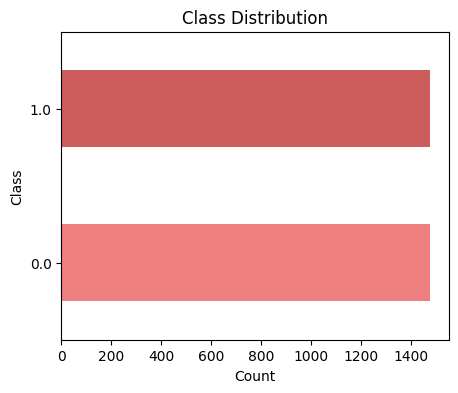

In [104]:
plot_class_dist(y_smote)

### Random Undersampling

In [105]:
# Randomly remove instances from the majority class.

def random_under_sample(X_train, y_train, sampling_strategy='auto', random_state=42):
    
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_state)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    
    return X_resampled, y_resampled

In [106]:
X_rus, y_rus = random_under_sample(X_train, y_train)

log_reg = LogisticRegression()
log_reg.fit(X_rus, y_rus)

evaluate_model_metrics(log_reg,X_rus, y_rus,X_val, y_val)


Train Accuracy: 0.864

Test Accuracy: 0.878

Precision: 0.679

Recall: 0.827

F1-Score: 0.746


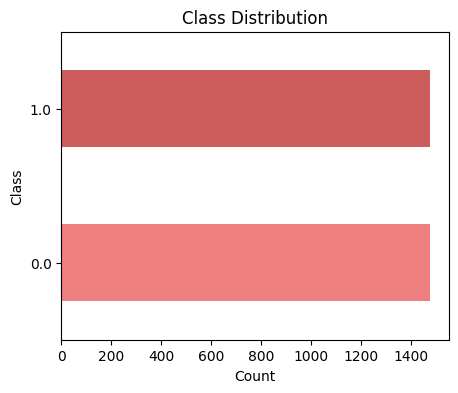

In [107]:
plot_class_dist(y_smote)

### Tomek Links

In [108]:
# Identify and remove pairs of instances from different classes that are very close to each other.

def tomek_links(X_train, y_train, sampling_strategy='auto', random_state=42):
    
    tl = TomekLinks(sampling_strategy='auto')
    X_resampled, y_resampled = tl.fit_resample(X_train, y_train)

    
    return X_resampled, y_resampled

In [109]:
X_tomek, y_tomek = tomek_links(X_train, y_train)

log_reg = LogisticRegression()
log_reg.fit(X_tomek, y_tomek)

evaluate_model_metrics(log_reg,X_tomek, y_tomek, X_val, y_val)


Train Accuracy: 0.928

Test Accuracy: 0.932

Precision: 0.937

Recall: 0.738

F1-Score: 0.825


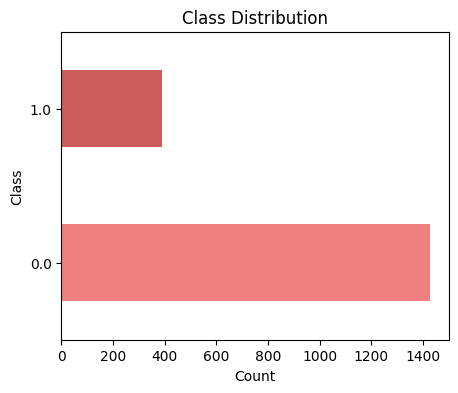

In [110]:
plot_class_dist(y_tomek)

### SMOTE + Tomek Links

In [111]:
# Combine SMOTE for oversampling the minority class with Tomek Links to clean the dataset.

def smote_tomek(X_train, y_train, sampling_strategy='auto', random_state=42):
    
    smt = SMOTETomek(sampling_strategy=sampling_strategy, random_state=random_state)
    X_resampled, y_resampled = smt.fit_resample(X_train, y_train)
    
    return X_resampled, y_resampled

In [112]:
X_smote_tomek, y_smote_tomek = smote_tomek(X_train, y_train)

log_reg = LogisticRegression()
log_reg.fit(X_smote_tomek, y_smote_tomek)

evaluate_model_metrics(log_reg,X_smote_tomek, y_smote_tomek, X_val, y_val)


Train Accuracy: 0.880

Test Accuracy: 0.896

Precision: 0.731

Recall: 0.822

F1-Score: 0.774


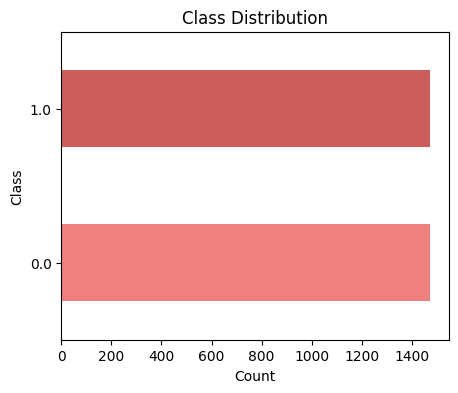

In [113]:
plot_class_dist(y_smote_tomek)

In [86]:
# no need of oversampling or undersampling

## Hyperparameter Optimization

In [114]:
# It is the process of finding the right combination of hyperparameter values 
# to achieve maximum performance on the data in a reasonable amount of time

### Grid Search

In [115]:
# Grid search is an exhaustive method to find optimal values for hyperparameters

# Hyperparameters
param_grid = {
    
    'penalty': ['l1', 'l2','None'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['newton-cg','saga','lbfgs'],
    'max_iter': [100,200,300],
    'class_weight': [None, 'balanced'],
    'warm_start': [False, True],
    
}

In [116]:
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search.fit(X_train, y_train)

clear_output()     # to clear warnings

In [117]:
# Best hyperparameters
grid_best_params = grid_search.best_params_
grid_best_params

{'C': 0.1,
 'class_weight': None,
 'max_iter': 200,
 'penalty': 'l1',
 'solver': 'saga',
 'warm_start': False}

In [118]:
# Model with the best hyperparameters
log_reg_grid = grid_search.best_estimator_

In [119]:
evaluate_model_metrics(log_reg_grid,X_train,y_train,X_val,y_val)


Train Accuracy: 0.930

Test Accuracy: 0.929

Precision: 0.966

Recall: 0.698

F1-Score: 0.810


In [120]:
# Function to perform grid search optimisation

def grid_search_optimize(model, param_grid, X_train, y_train, cv,
                         scoring='accuracy', verbose=0, n_jobs=-1):
    
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, 
                               scoring=scoring, verbose=verbose, n_jobs=n_jobs)
    
    grid_search.fit(X_train, y_train)
    clear_output()
    
    grid_best_params = grid_search.best_params_
    grid_best_model = grid_search.best_estimator_
    
    return grid_best_params, grid_best_model

### Random Search

In [121]:
# Random Search is faster than grid search due to less iterations performed but it may not be optimal 

def random_search_optimize(model,param,n_iter,cv,X_train, y_train,
                           scoring='accuracy', n_jobs=-1, verbose=0):
    
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param,
        n_iter=n_iter, 
        scoring=scoring, 
        cv=cv, 
        n_jobs=n_jobs, 
        verbose=verbose
    )

    random_search.fit(X_train, y_train)
    clear_output()

    rand_best_params = random_search.best_params_
    rand_best_model = random_search.best_estimator_
    
    return rand_best_params, rand_best_model

In [122]:
rand_best_params, log_reg_rand = random_search_optimize(LogisticRegression(),param_grid,100,5,X_train, y_train,
                                                            scoring='accuracy', n_jobs=-1, verbose=0)
rand_best_params

{'warm_start': True,
 'solver': 'saga',
 'penalty': 'l1',
 'max_iter': 200,
 'class_weight': None,
 'C': 0.1}

In [123]:
evaluate_model_metrics(log_reg_rand,X_train,y_train,X_val,y_val)


Train Accuracy: 0.930

Test Accuracy: 0.929

Precision: 0.966

Recall: 0.698

F1-Score: 0.810


### OPTUNA

In [124]:
# Optuna is an automatic hyperparameter optimization software framework

def objective(trial):
    
    # Hyperparameter search space
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    solver = trial.suggest_categorical('solver', ['newton-cg', 'saga', 'lbfgs',
                                                  'liblinear','sag'])
    if (penalty == "l1" and solver not in ["liblinear", "saga"]) or (penalty == "elasticnet" and solver not in ["saga"]) or penalty=='none' and solver in ['liblinear']:
        return 0
    max_iter = trial.suggest_int('max_iter', 100, 300, 500)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    warm_start = trial.suggest_categorical('warm_start', [False, True])
    fit_intercept = trial.suggest_categorical('fit_intercept', [False, True])

    model = LogisticRegression(
        penalty=penalty, C=C, solver=solver, max_iter=max_iter,
        class_weight=class_weight, warm_start=warm_start, fit_intercept=fit_intercept
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [125]:
def optuna_optimize(n_trials=100,direction='maximum',n_jobs=-1):
    
    study = optuna.create_study(direction='maximize')  # 'maximize' for accuracy, 'minimize' for loss
    study.optimize(objective, n_trials=n_trials, n_jobs=n_jobs)
    clear_output()
    
    best_trial = study.best_trial.params
    log_reg_opt = LogisticRegression(**best_trial)
    
    return best_trial, log_reg_opt

In [126]:
# Best optuna paramaters
best_trial, log_reg_opt = optuna_optimize(n_trials=100)

best_trial

{'penalty': 'l2',
 'C': 0.5670214468462241,
 'solver': 'sag',
 'max_iter': 100,
 'class_weight': None,
 'warm_start': False,
 'fit_intercept': True}

In [127]:
log_reg_opt.fit(X_train,y_train)

evaluate_model_metrics(log_reg_opt,X_train,y_train,X_val,y_val)

# Optuna seems to give good hyperparameters with lesser cost


Train Accuracy: 0.931

Test Accuracy: 0.932

Precision: 0.960

Recall: 0.718

F1-Score: 0.822


## Evaluation on Test Set


Train Accuracy: 0.931

Test Accuracy: 0.929

Precision: 0.949

Recall: 0.686

F1-Score: 0.796

Confusion Matrix:

[[738   7]
 [ 59 129]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.93      0.99      0.96       745
     Class 1       0.95      0.69      0.80       188

    accuracy                           0.93       933
   macro avg       0.94      0.84      0.88       933
weighted avg       0.93      0.93      0.92       933


ROC-AUC Curve:


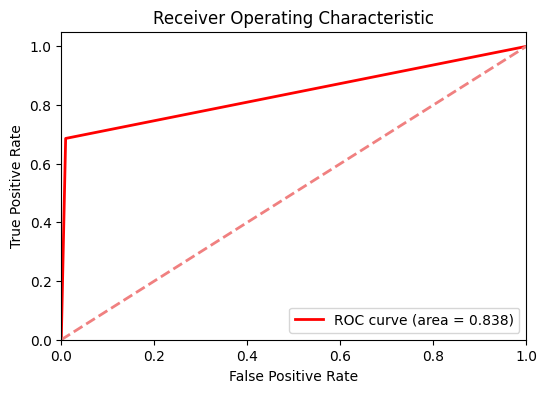

In [129]:
# After evaluating on the validation set, we evaluate and finalize on the test set

log_reg_final = LogisticRegression(**log_reg_opt.get_params())
log_reg_final.fit(X_train, y_train)

evaluate_model_metrics(log_reg_final , X_train, y_train, X_test, y_test, verbose=6)

## Cross Validation

In [130]:
# It is a technique used to evaluate the performance of a model on unseen data.
# It involves dividing the available data into multiple folds or subsets, 
# using one of these folds as a validation set, and training the model on the remaining folds.

### K-fold

In [143]:
# The dataset is divided into k subsets or folds. 
# The model is trained and evaluated k times, using a different fold as the validation set each time. 
# Performance metrics from each fold are averaged to estimate the model's generalization performance.

scores = cross_val_score(LogisticRegression(**log_reg_grid.get_params()), X, y, cv=10, scoring='accuracy')

print("Scores:", scores)

Scores: [0.93589744 0.93162393 0.91452991 0.93562232 0.92274678 0.91845494
 0.93562232 0.94849785 0.92274678 0.92274678]


In [144]:
mean_accuracy = scores.mean()
std_accuracy = scores.std()

print("\nMean Accuracy: ", mean_accuracy)
print("\nStandard Deviation: ", std_accuracy)


Mean Accuracy:  0.9288489050291625

Standard Deviation:  0.009797947907704082


In [145]:
def k_cross_validate(model,X_train, y_train,cv,scoring='accuracy',n_jobs=-1):
    
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    
    mean_score = scores.mean()
    std_score = scores.std()
    
    print(f"\n{scoring} scores:", scores)
    print(f"\nMean {scoring} score: ", mean_score)
    print("\nStandard deviation: ", std_score)

In [146]:
k_cross_validate(LogisticRegression(),X_train, y_train,cv=10,scoring='accuracy',n_jobs=-1)


accuracy scores: [0.93162393 0.93589744 0.92735043 0.92274678 0.93133047 0.91845494
 0.92703863 0.94849785 0.92703863 0.91416309]

Mean accuracy score:  0.9284142181137888

Standard deviation:  0.009041436465159336


In [147]:
k_cross_validate(LogisticRegression(**log_reg_grid.get_params()),X_train, y_train,cv=10,scoring='accuracy',n_jobs=-1)


accuracy scores: [0.93589744 0.93162393 0.91452991 0.93562232 0.92274678 0.91845494
 0.93562232 0.94849785 0.92274678 0.92274678]

Mean accuracy score:  0.9288489050291625

Standard deviation:  0.009797947907704082


In [148]:
k_cross_validate(LogisticRegression(**log_reg_opt.get_params()),X_train, y_train,cv=10,scoring='accuracy',n_jobs=-1)


accuracy scores: [0.93162393 0.93162393 0.92735043 0.92274678 0.92703863 0.91416309
 0.92703863 0.94849785 0.91845494 0.91845494]

Mean accuracy score:  0.9266993140383699

Standard deviation:  0.009127175118793627


### Stratified K-fold

In [138]:
# Stratified k-fold ensures that each fold maintains the same class distribution as the entire dataset.
# It's useful when dealing with imbalanced datasets, where one class significantly outnumbers the other.

In [151]:
def stratified_k_cross_validate(model,X, y,n_splits,shuffle=True,verbose=0,random_state=42):
    
    X = X.values
    y = y.values

    stratified_kf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    scores = []

    # Stratified k-fold cross-validation
    for train_index, test_index in stratified_kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        confusion = confusion_matrix(y_test, y_pred)

        scores.append([accuracy,precision,recall,f1,confusion])

        average_accuracy = np.mean([item[0] for item in scores])
        average_precision = np.mean([item[1] for item in scores])
        average_recall = np.mean([item[2] for item in scores])
        average_f1 = np.mean([item[3] for item in scores])

    for fold, score in enumerate(scores, 1):
        if verbose >= 1:
            print(f"Fold {fold}: ")
            print(f"Accuracy: {score[0]:.3f}")
        
        if verbose >= 2:
            print(f"Precision: {score[1]:.3f}")

        if verbose >= 3:
            print(f"Recall: {score[2]:.3f}")

        if verbose >= 4:
            print(f"F1-Score: {score[3]:.3f}")

        if verbose >= 5:
            print(f"Confusion Matrix:\n {score[4]}")
            
        if verbose >= 1:
            print('')

    print(f"\nAverage Accuracy: {average_accuracy}")
    print(f"\nAverage Precision: {average_precision}")
    print(f"\nAverage Recall: {average_recall}")
    print(f"\nAverage F1-Score: {average_f1}")

In [152]:
stratified_k_cross_validate(LogisticRegression(),X_train, y_train,n_splits=10,verbose=4)

Fold 1: 
Accuracy: 0.930
Precision: 0.933
Recall: 0.718
F1-Score: 0.812

Fold 2: 
Accuracy: 0.930
Precision: 0.882
Recall: 0.769
F1-Score: 0.822

Fold 3: 
Accuracy: 0.930
Precision: 1.000
Recall: 0.667
F1-Score: 0.800

Fold 4: 
Accuracy: 0.930
Precision: 0.933
Recall: 0.718
F1-Score: 0.812

Fold 5: 
Accuracy: 0.920
Precision: 0.900
Recall: 0.692
F1-Score: 0.783

Fold 6: 
Accuracy: 0.930
Precision: 1.000
Recall: 0.667
F1-Score: 0.800

Fold 7: 
Accuracy: 0.925
Precision: 0.931
Recall: 0.692
F1-Score: 0.794

Fold 8: 
Accuracy: 0.925
Precision: 0.879
Recall: 0.744
F1-Score: 0.806

Fold 9: 
Accuracy: 0.925
Precision: 0.963
Recall: 0.667
F1-Score: 0.788

Fold 10: 
Accuracy: 0.935
Precision: 0.966
Recall: 0.718
F1-Score: 0.824


Average Accuracy: 0.9281869932723822

Average Precision: 0.938732217373191

Average Recall: 0.7051282051282051

Average F1-Score: 0.8038796311926328


In [153]:
stratified_k_cross_validate(LogisticRegression(**log_reg_grid.get_params()),X_train, y_train,n_splits=10,verbose=1)

Fold 1: 
Accuracy: 0.941

Fold 2: 
Accuracy: 0.930

Fold 3: 
Accuracy: 0.936

Fold 4: 
Accuracy: 0.930

Fold 5: 
Accuracy: 0.925

Fold 6: 
Accuracy: 0.920

Fold 7: 
Accuracy: 0.925

Fold 8: 
Accuracy: 0.930

Fold 9: 
Accuracy: 0.925

Fold 10: 
Accuracy: 0.930


Average Accuracy: 0.9292565119889596

Average Precision: 0.9693021346469622

Average Recall: 0.6846153846153846

Average F1-Score: 0.8014551324777448


In [154]:
stratified_k_cross_validate(LogisticRegression(**log_reg_opt.get_params()),X_train, y_train,n_splits=10)


Average Accuracy: 0.9260450807889138

Average Precision: 0.9436377721277609

Average Recall: 0.6897435897435897

Average F1-Score: 0.795905724072265


### Save Model

In [155]:
final_log_reg = LogisticRegression()
final_log_reg.fit(X_train, y_train)

final_log_reg_estimator = log_reg

In [156]:
# Saving the model

model_dir = "../Models/Diabetes"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

def save_model(model, path):

    q = ''
    
    if os.path.exists(path):
        q = input('Overwrite File? [y/n]: ')

    if q.lower() == 'y' or not os.path.exists(path):
        try:
            joblib.dump(model, path)
            print('Saved Model')

        except Exception as err:
            print('Error while saving model: ',err)
    else:
        clear_output()

In [157]:
save_model(final_log_reg_estimator, '../Models/Diabetes/Logistic Regression.pkl')

Overwrite File? [y/n]: y
Saved Model


## Prediction

In [158]:
# Let us use the model to predict from values from the dataset by slightly modyfying it
# The modified values are still close to the original values so that their class might be the same

# Function to perturb values
def perturb_row(row, scale=0.15):
    perturbed_row = row.copy()

    for i in range(1,len(row)):
        perturbation = np.random.normal(0, scale)
        
        perturbed_row[i] += perturbation

    return perturbed_row

# Prediction
row = X_test.iloc[0]
print('Instance:\n',row.values)
print('\nExpected Class: ',y_test.iloc[0])

new_row = perturb_row(row, scale=0.15)
new_row
print('\n Modified Instance:\n',new_row.values)

prediction = final_log_reg_estimator.predict(np.array(new_row).reshape(1, -1))
print('\nPredicted Class: ', prediction)

Instance:
 [-0.99903015 -0.13496567  1.99009074 -0.84791093  0.39029008  1.1727009
 -0.6915082  -0.47508376  0.01456525  0.45051657  1.27403456 -0.389722
 -0.21592878 -0.11955639 -1.06979676 -0.18069442 -0.03287429  1.69372043
  0.27721042 -0.79975306 -0.71895859  0.47238078 -0.88917697]

Expected Class:  0.0

 Modified Instance:
 [-0.99903015  0.12536702  1.85632714 -0.75494256  0.25729533  0.99772162
 -0.6168836  -0.3979049   0.27154554  0.4492797   1.13926894 -0.1315864
 -0.04543794 -0.29652394 -1.07441177  0.0228873   0.01452721  1.74967443
  0.09670173 -0.610494   -0.65160962  0.570178   -1.00523909]

Predicted Class:  [0.]


In [159]:
# Function to predict on perturbed values

def predict_on_modified_instance(model, row, label, scale=0.15):
    
    def perturb_row(row, scale=0.5):
        perturbed_row = row.copy()

        for i in range(1,len(row)):
            perturbation = np.random.normal(0, scale)

            perturbed_row[i] += perturbation

        return perturbed_row

    # Prediction
    print('Instance:\n',row.values)
    print('\nExpected Class: ',label)

    new_row = perturb_row(row, scale=0.15)
    new_row
    print('\n Modified Instance:\n',new_row.values)
    prediction = model.predict(np.array(new_row).reshape(1, -1))
    print('\nPredicted Class: ', prediction)

In [160]:
predict_on_modified_instance(final_log_reg_estimator, X_test.iloc[11], y_test.iloc[11], 0.15)

Instance:
 [-3.39131793 -0.13496567 -1.2375996   0.38118357  0.63177805 -1.78111664
 -0.61206145 -0.64536926 -0.46318647 -0.21942057  0.80648749 -0.39746574
 -0.38266339 -0.42222642  1.11947462 -0.44217234  0.03952156 -1.46309745
  3.31369829 -0.06582577 -1.9382715  -0.16860699 -0.577721  ]

Expected Class:  0.0

 Modified Instance:
 [-3.39131793 -0.15489295 -1.12422384  0.20140265  0.43023509 -1.79527533
 -0.55543491 -0.77405025 -0.43032974 -0.25071773  0.97688333 -0.344766
 -0.29845429 -0.40984526  1.03002634 -0.37912248 -0.01594205 -1.47517504
  3.4272493   0.23285198 -1.80430632 -0.1380593  -0.54349851]

Predicted Class:  [0.]
